# Homework 2 
**name:** Mina Stojanovic  
**github id:** minastoj  
**USC student id:** 4968308304  

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

### Question 1
#### (b) Exploring the data:
i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [28]:
# create columns names for each variable/feature
columns = ['AT', 'V', 'AP', 'RH', 'PE']

# REFERENCE: Site #1
# load excel file located in ../data/CCPP into dataframe (includes header)
data = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx', header=0, names=columns)

# REFERENCE: Site #2
# print out metrics of dataset
print(f"Number of Rows in the dataset: {len(data.index)}")
print(f"Number of Columns in the dataset: {len(data.columns)}")
print("Each row represents one observation, while each column represents one feature/variable. Each observation has 4 features and 1 target variable.")

Number of Rows in the dataset: 9568
Number of Columns in the dataset: 5
Each row represents one observation, while each column represents one feature/variable. Each observation has 4 features and 1 target variable.


ii. Make pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

<Figure size 1080x864 with 0 Axes>

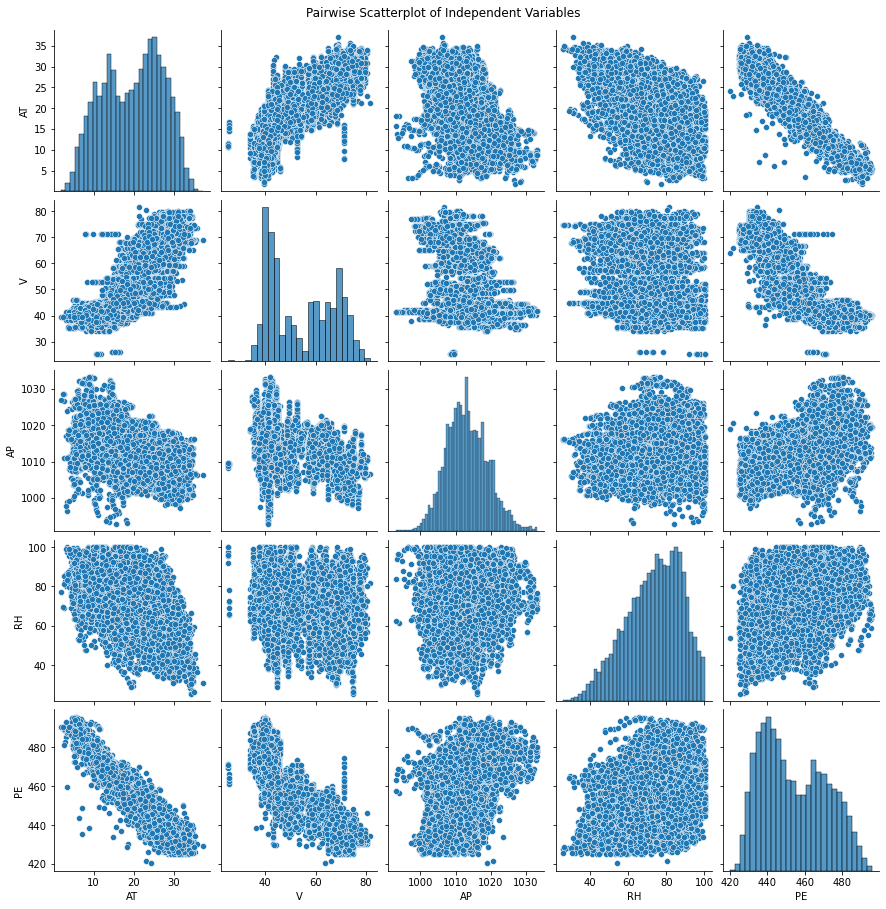

From a first glance, it seems that only AT and maybe V have a somewhat negatively linear relationship with PE. As AT or V increases, PE decreases.
AP and RH seem a little bit all over the place, but it seems like there is a slightly linear correlation between AP and PE, as well as RH and PE.


In [29]:
# get dependent variable (final column)
dependent_var = data['PE']

# get independent variables
independent_vars = data.drop('PE', axis=1)

# REFERENCE: Site #3
# actually plot each pair of independent variables
plt.figure(figsize=(15, 12))
sns.pairplot(data)
plt.suptitle('Pairwise Scatterplot of Independent Variables', y=1.01)
plt.show()

print("From a first glance, it seems that only AT and maybe V have a somewhat negatively linear relationship with PE. As AT or V increases, PE decreases.")
print("AP and RH seem a little bit all over the place, but it seems like there is a slightly linear correlation between AP and PE, as well as RH and PE.")

iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [30]:
metrics = [] # use to make a table of metrics

# for each of the variables in the dataset, get metrics
for column in columns:
    mean = data[column].mean()
    median = data[column].median()
    range_val = data[column].max() - data[column].min()
    quartile1 = data[column].quantile(0.25)
    quartile3 = data[column].quantile(0.75)
    quartile_range = quartile3 - quartile1
    
    # add to metrics list (dictionary preserves order)
    metrics.append({
        'Variable': column,
        'Mean': mean,
        'Median': median,
        'Range': range_val,
        '1st Quartile': quartile1,
        '3rd Quartile': quartile3,
        'Interquartile Range': quartile_range
    })

# print table of metrics
metrics_df = pd.DataFrame(metrics)
pd.set_option('display.float_format', '{:.3f}'.format)
# REFERENCE: Site #4
display(metrics_df)

,Variable,Mean,Median,Range,1st Quartile,3rd Quartile,Interquartile Range
0,AT,19.651,20.345,35.300,13.510,25.720,12.210
1,V,54.306,52.080,56.200,41.740,66.540,24.800
2,AP,1013.259,1012.940,40.410,1009.100,1017.260,8.160
3,RH,73.309,74.975,74.600,63.328,84.830,21.502
4,PE,454.365,451.550,75.500,439.750,468.430,28.680


#### (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

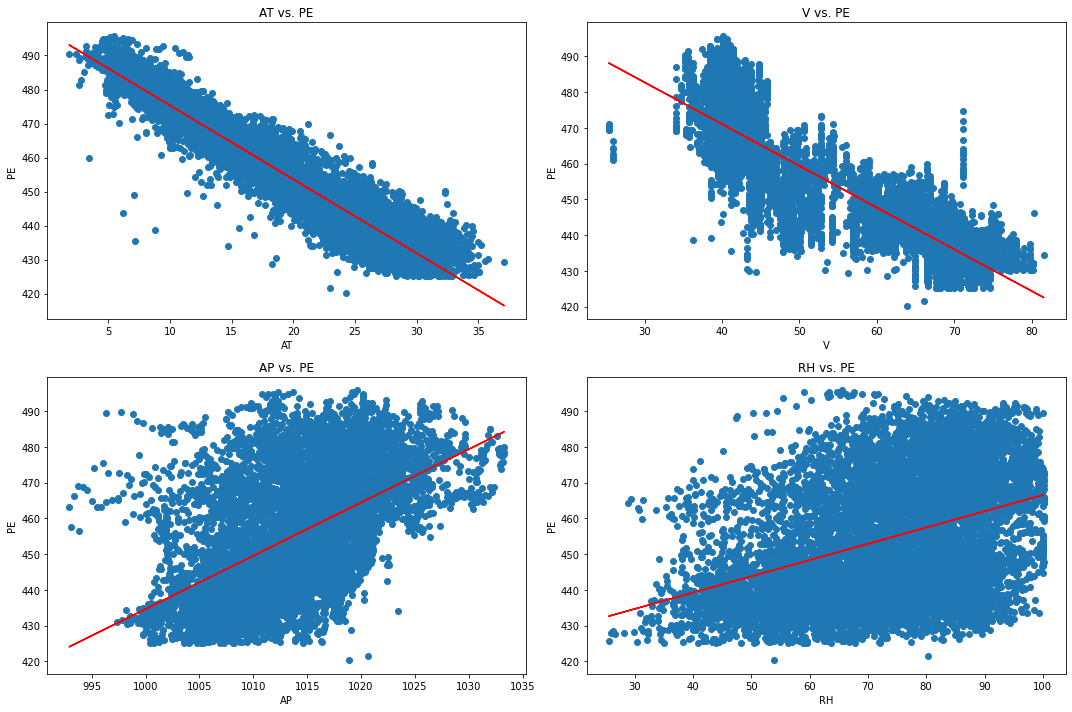

,Variable,P-Value,Number of Outliers,Statistically Significant
0,AT,0.000,449,True
1,V,0.000,553,True
2,AP,0.000,402,True
3,RH,0.000,244,True


In [31]:
univar_coefficients = [] # to be used in question 1d

p_values = []
num_outliers = []
statistically_significant = []

# create subplots for each independent variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# for each predictor, create a linear regression
for i, column in enumerate(independent_vars):
    # REFERENCE: Site #5
    # create linear regression model using sm.ols
    X = sm.add_constant(independent_vars[column])
    model = sm.OLS(dependent_var, X).fit()

    # make plot for model
    axes[i].scatter(independent_vars[column], dependent_var) # all points
    axes[i].plot(independent_vars[column], model.predict(X), color='red') # regression line
    
    # titles and labels
    axes[i].set_title(f'{column} vs. PE')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('PE')

    # determine statistical significance (p < 0.05)
    curr_pval = model.pvalues[1]
    p_values.append(curr_pval)
    if(curr_pval < 0.05):
        statistically_significant.append(True)
    else:
        statistically_significant.append(False)

    # REFERENCE: Site #6
    outliers = model.outlier_test()
    outliers = outliers[outliers['unadj_p'] < 0.05]
    if(len(outliers) > 0):
        num_outliers.append(len(outliers))

    # add coefficient to list (for 1d)
    univar_coefficients.append(model.params[1])

# show plot
plt.tight_layout()
plt.show()

results = []
# loop through each variable and add to results
for i in range(4):
    results.append({
        'Variable': columns[i],
        'P-Value': p_values[i],
        'Number of Outliers': num_outliers[i],
        'Statistically Significant': statistically_significant[i]
    })

# print table of results
results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.3f}'.format)
display(results_df)

#### (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

In [32]:
multivar_coefficients = [] # to be used in question 1d

p_values = []
can_reject_null = []

# REFERENCE: Site #5
X = sm.add_constant(independent_vars)
model = sm.OLS(dependent_var, X).fit()

# determine which variables are statistically significant/can reject null hypothesis
for i, curr_pval in enumerate(model.pvalues):
    if i == 0: continue # skip constant term

    column_name = independent_vars.columns[i - 1]
    p_values.append(curr_pval)

    if curr_pval < 0.05:
        can_reject_null.append(True)
        # print(f"{column_name} is statistically significant with a p-value of {curr_pval}. We can reject the null hypothesis.")
    else:
        can_reject_null.append(False)
        # print(f"{column_name} is not statistically significant with a p-value of {curr_pval}. We cannot reject the null hypothesis.")

results = []
# loop through each variable and add to results
for i in range(4):
    results.append({
        'Variable': columns[i],
        'P-Value': model.pvalues[i],
        'Can Reject Null Hypothesis': model.pvalues[i] < 0.05
    })

# print table of results
results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.3f}'.format)
display(results_df)

# add coefficients to list (for 1d)
multivar_coefficients = model.params[1:]

,Variable,P-Value,Can Reject Null Hypothesis
0,AT,0.000,True
1,V,0.000,True
2,AP,0.000,True
3,RH,0.000,True


#### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

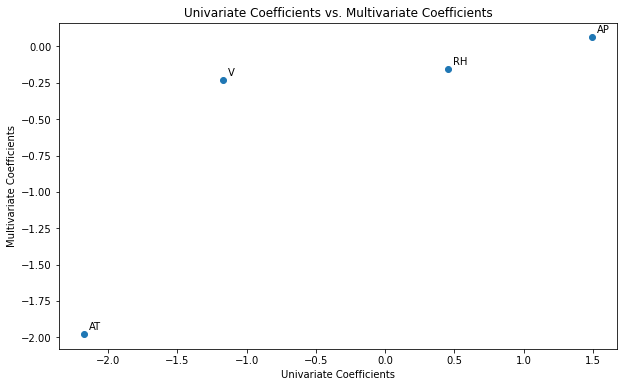

In [33]:
# plot univar coefficients vs multivar coefficients
plt.figure(figsize=(10, 6))
plt.scatter(univar_coefficients, multivar_coefficients)
plt.title('Univariate Coefficients vs. Multivariate Coefficients')
plt.xlabel('Univariate Coefficients')
plt.ylabel('Multivariate Coefficients')

# REFERENCE: Site #7
# label each dot with it's corresponding variable
for i, column in enumerate(independent_vars):
    plt.annotate(column, (univar_coefficients[i], multivar_coefficients[i]), xytext=(5, 5), textcoords='offset points')

plt.show()

#### (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form: Y = β0 + β1X + β2X^2 + β3X^3 + ε

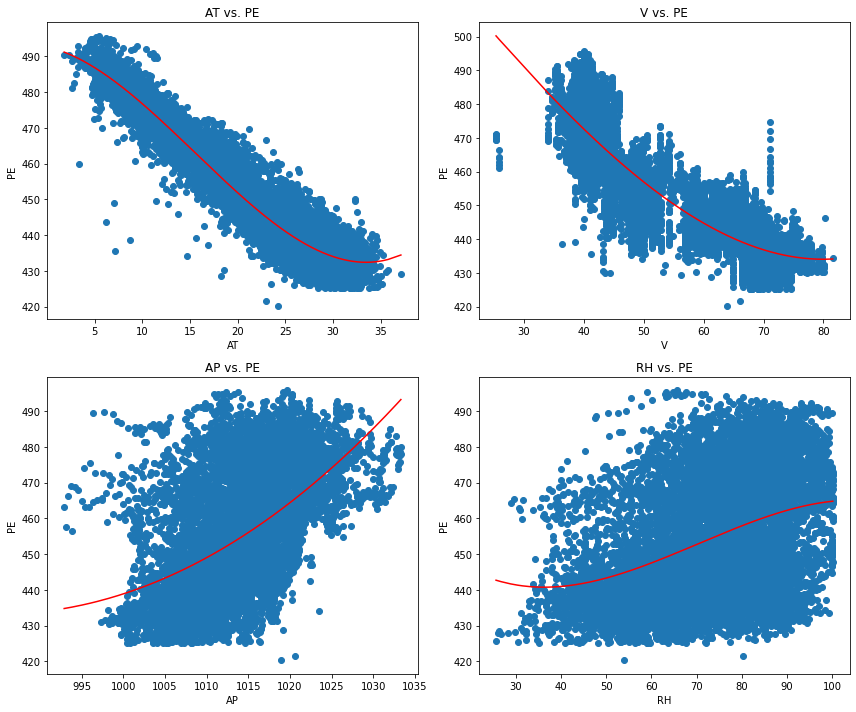

In [34]:
# create subplots for each independent variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# REFERENCE: Site #8
# for each predictor x, fit a polynomial regression
for i, column in enumerate(independent_vars.columns):
    # generates polynomials for input
    polynomial_features = PolynomialFeatures(degree=3)
    input_polynomial = polynomial_features.fit_transform(independent_vars[column].values.reshape(-1, 1))

    # create model like normal with statsmodel
    model = sm.OLS(dependent_var, input_polynomial).fit()
    predictions = model.predict(input_polynomial)

    # REFERENCE: Site #9
    # sorting inputs, outputs, and predictions will fix multiple linear regression issue
    sorted_indices = np.argsort(independent_vars[column])
    sorted_X = independent_vars[column].values[sorted_indices]
    sorted_predictions = predictions[sorted_indices]

    # I asked ChatGPT to help me sort the values, since I was having issues with it after following the referenced site above.
    # My Query: in python, can you sort two arrays, independent_vars and predictions to match orders?
    # ChatGPT Response:
    # To sort two arrays, independent_vars and predictions, such that both are aligned based on the order of independent_vars, 
    # you can use numpy or sorted() in Python. Here's an example using numpy:
    # # Get the sorted indices based on independent_vars
    # sorted_indices = np.argsort(independent_vars)
    # # Sort both arrays based on these indices
    # independent_vars_sorted = independent_vars[sorted_indices]
    # predictions_sorted = predictions[sorted_indices]

    # plot the model
    axes[i].scatter(independent_vars[column], dependent_var) # all points from before
    axes[i].plot(sorted_X, sorted_predictions, color='red') # polynomial regression line
    axes[i].set_title(f'{column} vs. PE')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('PE')

# show plot
plt.tight_layout()
plt.show()

#### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [35]:
interaction_terms = []
p_values = []
statistically_significant = []

# REFERENCE: Site #10
# Create interaction terms (pairwise interactions)
for pair in itertools.combinations(independent_vars, 2):
    interaction_terms.append('{}:{}'.format(pair[0], pair[1]))

# REFERENCE: Site #11
# create formula with interaction terms for model
formula = '{} ~ {} + {}'.format('PE', ' + '.join(independent_vars), ' + '.join(interaction_terms))
model = sm.OLS.from_formula(formula, data).fit()

# determine which interaction terms are statistically significant
for i, curr_pval in enumerate(model.pvalues):
    if i < 5: continue # skip constant and non-interaction terms

    column_name = interaction_terms[i - 5]
    p_values.append(curr_pval)
    if curr_pval < 0.05:
        statistically_significant.append(True)
        # print(f"{column_name} is statistically significant with a p-value of {curr_pval:0.5f}.")
    else:
        statistically_significant.append(False)

results = []
# loop through each variable and add to results
for i in range(len(interaction_terms)):
    results.append({
        'Interaction Term': interaction_terms[i],
        'P-Value': p_values[i],
        'Statistically Significant': statistically_significant[i]
    })

# print table of results
results_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.5f}'.format)
display(results_df)

,Interaction Term,P-Value,Statistically Significant
0,AT:V,0.00000,True
1,AT:AP,0.45205,False
2,AT:RH,0.00000,True
3,V:AP,0.00000,True
4,V:RH,0.08619,False
5,AP:RH,0.03361,True


#### (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [36]:
# REFERENCE: Site #12
# randomly select 70% of predictors for training (and the rest for testing)
training_data = data.sample(frac=0.7)
testing_data = data.drop(training_data.index)

# !!! MODEL 1: REGULAR REGRESSION !!!
# get training data
training_x = training_data.drop('PE', axis=1)
training_y = training_data['PE']

# train regression on training data
X_train = sm.add_constant(training_x)
model = sm.OLS(training_y, X_train).fit()

# get testing data
testing_x = testing_data.drop('PE', axis=1)
testing_y = testing_data['PE']

X_test = sm.add_constant(testing_x)

# -------------------------------------------- #

# !!! MODEL 2: AUGMENTED REGRESSION !!!
# Linear terms: X1, X2, X3, X4
formula = ' + '.join(independent_vars.columns)

# REFERENCE: Site #10, 13
# Quadratic terms: X1^2, X2^2, X3^2, X4^2
quadratic_terms = ['I({}**2)'.format(var) for var in independent_vars.columns]
formula += ' + ' + ' + '.join(quadratic_terms)

# Two-way interactions: X1_X2, X1_X3, X1_X4, X2_X3, X2_X4, X3_X4
for pair in itertools.combinations(independent_vars.columns, 2):
    formula += ' + ' + '*'.join(pair)

# Three-way interactions: X1_X2_X3, X1_X2_X4, X1_X3_X4, X2_X3_X4
for triplet in itertools.combinations(independent_vars.columns, 3):
    formula += ' + ' + '*'.join(triplet)

# Four-way interaction: X1_X2_X3_X4
formula += ' + ' + '*'.join(independent_vars.columns)

# finalize formula by including "PE ~ "
final_formula = '{} ~ {}'.format('PE', formula)

# train regression on training data
model_2 = sm.OLS.from_formula(final_formula, training_data).fit()

# remove all terms that are not statistically significant
for i, curr_pval in enumerate(model_2.pvalues):
    if(i == 0): continue # skip intercept

    if curr_pval > 0.05:
        term = model_2.params.index[i]
        term = term.replace(' ', '') # remove spaces causing issues with finding term
        final_formula = final_formula.replace(' + ' + term, '')

# train model_3 to be model_2 with only significant terms
model_3 = sm.OLS.from_formula(final_formula, training_data).fit()

# -------------------------------------------- #

# get predictions for both models
model_1_train_pred = model.predict(X_train)
model_1_test_pred = model.predict(X_test)
model_2_train_pred = model_2.predict(X_train)
model_2_test_pred = model_2.predict(X_test)
model_3_train_pred = model_3.predict(X_train)
model_3_test_pred = model_3.predict(X_test)

results = [] # storing MSE table info 

# REFERENCE: Site #14
model_1_train_MSE = mean_squared_error(model_1_train_pred, training_y)
model_1_test_MSE = mean_squared_error(model_1_test_pred, testing_y)
results.append({
    'Model': 'Linear Regression',
    'Training MSE': model_1_train_MSE,
    'Testing MSE': model_1_test_MSE
})

# REFERENCE: Site #14
model_2_train_MSE = mean_squared_error(model_2_train_pred, training_y)
model_2_test_MSE = mean_squared_error(model_2_test_pred, testing_y)
results.append({
    'Model': 'Regression w/ Interaction Terms',
    'Training MSE': model_2_train_MSE,
    'Testing MSE': model_2_test_MSE
})

# REFERENCE: Site #14
model_3_train_MSE = mean_squared_error(model_3_train_pred, training_y)
model_3_test_MSE = mean_squared_error(model_3_test_pred, testing_y)
results.append({
    'Model': 'Regression w/ Interaction Terms (Significant Only)',
    'Training MSE': model_3_train_MSE,
    'Testing MSE': model_3_test_MSE
})

# print out results in table
results_df = pd.DataFrame(results)
display(results_df)


,Model,Training MSE,Testing MSE
0,Linear Regression,20.62894,21.09854
1,Regression w/ Interaction Terms,17.51323,18.23515
2,Regression w/ Interaction Terms (Significant O...,17.51378,18.23662


#### (i) KNN Regression:
i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2,...,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

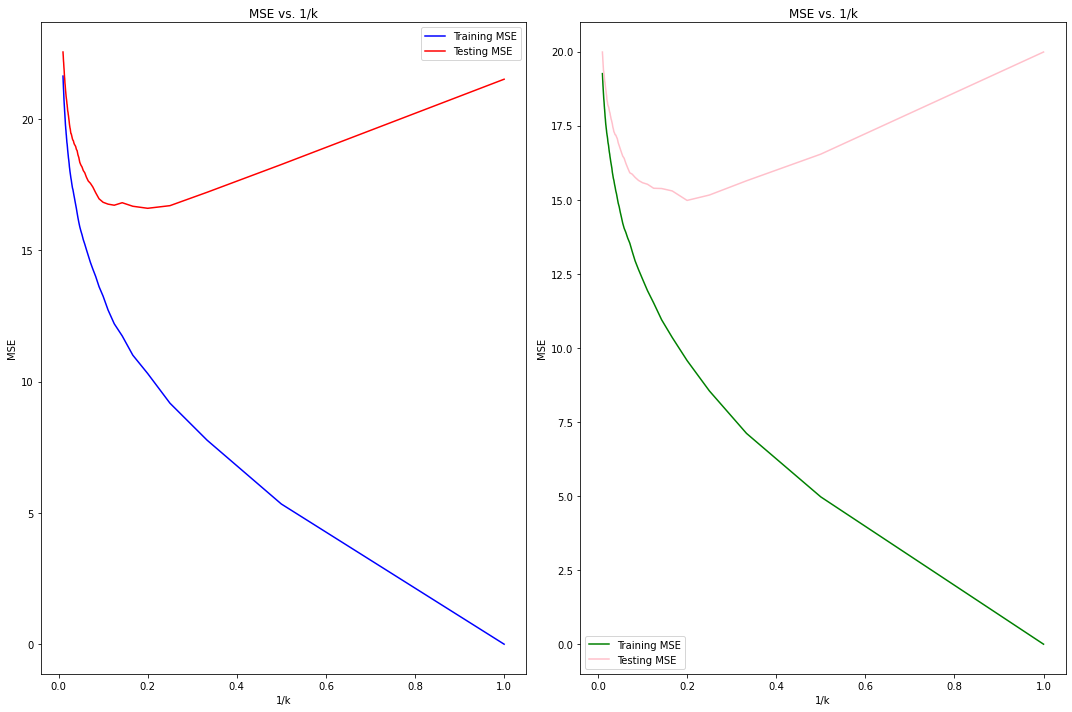

,Model,Best Training k,Best Training MSE,Best Testing k,Best Testing MSE
0,Raw Data,1,0.00000,5,16.60231
1,Scaled Data,1,0.00000,5,14.97585


In [37]:
# loop k from 1 to 100 inclusive
k_values = list(range(1, 101))
one_over_k = [1/k for k in k_values]

# training and testing errors for raw and scaled data
train_MSE_raw = []
test_MSE_raw = []
train_MSE_scaled = []
test_MSE_scaled = []

# training and testing best k for raw data
best_train_k_raw = None
best_train_MSE_raw = float('inf')
best_test_k_raw = None
best_test_MSE_raw = float('inf')

# training and testing best k for scaled data
best_train_k_scaled = None
best_train_MSE_scaled = float('inf')
best_test_k_scaled = None
best_test_MSE_scaled = float('inf')

# REFERENCE: Site #15
# normalized = scaled (& raw = unscaled)
scaler = StandardScaler()
training_x_scaled = scaler.fit_transform(training_x)
testing_x_scaled = scaler.transform(testing_x)

for k in k_values:
    # create KNN model with k neighbors
    knn = KNeighborsRegressor(n_neighbors=k)
    knn_scaled = KNeighborsRegressor(n_neighbors=k)

    knn.fit(training_x, training_y)
    knn_scaled.fit(training_x_scaled, training_y)

    # get predictions for training and testing data
    training_pred = knn.predict(training_x)
    testing_pred = knn.predict(testing_x)
    training_pred_scaled = knn_scaled.predict(training_x_scaled)
    testing_pred_scaled = knn_scaled.predict(testing_x_scaled)

    train_MSE_raw_datum = mean_squared_error(training_pred, training_y)
    test_MSE_raw_datum = mean_squared_error(testing_pred, testing_y)
    train_MSE_scaled_datum = mean_squared_error(training_pred_scaled, training_y)
    test_MSE_scaled_datum = mean_squared_error(testing_pred_scaled, testing_y)

    # calculate MSE for training and testing data
    train_MSE_raw.append(train_MSE_raw_datum)
    test_MSE_raw.append(test_MSE_raw_datum)
    train_MSE_scaled.append(train_MSE_scaled_datum)
    test_MSE_scaled.append(test_MSE_scaled_datum)

    # update best k values
    if(train_MSE_raw_datum < best_train_MSE_raw):
        best_train_k_raw = k
        best_train_MSE_raw = train_MSE_raw_datum

    if(test_MSE_raw_datum < best_test_MSE_raw):
        best_test_k_raw = k
        best_test_MSE_raw = test_MSE_raw_datum

    if(train_MSE_scaled_datum < best_train_MSE_scaled):
        best_train_k_scaled = k
        best_train_MSE_scaled = train_MSE_scaled_datum

    if(test_MSE_scaled_datum < best_test_MSE_scaled):
        best_test_k_scaled = k
        best_test_MSE_scaled = test_MSE_scaled_datum

# create subplots for kind of knn regression
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# plot raw MSE
axes[0].plot(one_over_k, train_MSE_raw, label='Training MSE', color='blue')
axes[0].plot(one_over_k, test_MSE_raw, label='Testing MSE', color='red')
axes[0].set_title('MSE vs. 1/k')
axes[0].set_xlabel('1/k')
axes[0].set_ylabel('MSE')
axes[0].legend()

# plot scaled MSE
axes[1].plot(one_over_k, train_MSE_scaled, label='Training MSE', color='green')
axes[1].plot(one_over_k, test_MSE_scaled, label='Testing MSE', color='pink')
axes[1].set_title('MSE vs. 1/k')
axes[1].set_xlabel('1/k')
axes[1].set_ylabel('MSE')
axes[1].legend()

plt.tight_layout()
plt.show()

# create table of best k values and MSE
results = []
results.append({
    'Model': 'Raw Data',
    'Best Training k': best_train_k_raw,
    'Best Training MSE': best_train_MSE_raw,
    'Best Testing k': best_test_k_raw,
    'Best Testing MSE': best_test_MSE_raw
})

results.append({
    'Model': 'Scaled Data',
    'Best Training k': best_train_k_scaled,
    'Best Training MSE': best_train_MSE_scaled,
    'Best Testing k': best_test_k_scaled,
    'Best Testing MSE': best_test_MSE_scaled
})

results_df = pd.DataFrame(results)
display(results_df)

#### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

In [38]:
final_results = [] # store final results from each kind of regression

final_results.append({
    'Model': 'Linear Regression',
    'Training MSE': model_1_train_MSE,
    'Testing MSE': model_1_test_MSE
})

final_results.append({
    'Model': 'Regression with Interaction Terms',
    'Training MSE': model_2_train_MSE,
    'Testing MSE': model_2_test_MSE
})

final_results.append({
    'Model': 'Regression with Significant Interaction Terms',
    'Training MSE': model_3_train_MSE,
    'Testing MSE': model_3_test_MSE
})

final_results.append({
    'Model': 'KNN Raw Regression',
    'Training MSE': best_train_MSE_raw,
    'Testing MSE': best_test_MSE_raw
})

final_results.append({
    'Model': 'KNN Scaled Regression',
    'Training MSE': best_train_MSE_scaled,
    'Testing MSE': best_test_MSE_scaled
})

final_results_df = pd.DataFrame(final_results)
pd.set_option('display.float_format', '{:.6f}'.format)
display(final_results_df)

print("In order of best to worst TRAINING MSE, the models are:")
print("1. KNN Raw Regression OR KNN Scaled Regression (both have MSE of 0.0)")
print("2. Regression with Interaction Terms")
print("3. Regression with Significant Interaction Terms")
print("4. Linear Regression\n")
print("In order of best to worst TESTING MSE, the models are:")
print("1. KNN Scaled Regression")
print("2. KNN Raw Regression")
print("2. Regression with Significant Interaction Terms")
print("3. Regression with Interaction Terms")
print("4. Linear Regression")

,Model,Training MSE,Testing MSE
0,Linear Regression,20.628943,21.098540
1,Regression with Interaction Terms,17.513228,18.235152
2,Regression with Significant Interaction Terms,17.513776,18.236622
3,KNN Raw Regression,0.000000,16.602311
4,KNN Scaled Regression,0.000000,14.975852


In order of best to worst TRAINING MSE, the models are:
1. KNN Raw Regression OR KNN Scaled Regression (both have MSE of 0.0)
2. Regression with Interaction Terms
3. Regression with Significant Interaction Terms
4. Linear Regression

In order of best to worst TESTING MSE, the models are:
1. KNN Scaled Regression
2. KNN Raw Regression
2. Regression with Significant Interaction Terms
3. Regression with Interaction Terms
4. Linear Regression


### Question 2
#### ISLR: 2.4.1: For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.
(a) The sample size n is extremely large, and the number of predictors p is small.  

In this case, a flexible method would be better because it can make sure of the large amount of data in order to represent all of the patterns. Additionally, with a large n, the risk of overfitting is reduced, allowing the flexible method to showcase the underlying relationships between the predictors and the result.  

(b) The number of predictors p is extremely large, and the number of observations n is small.  

When the number of predictors p is extremely large and the number of observations n is small, we would expect an inflexible model to work better than a flexible one. This is primarily due to the fact that there is not sufficient information about effects of each parameters in order to make a confident representation of the relationship between the predictors. In that case, a flexible model would overfit these predictors, which is an unwanted result.

(c) The relationship between the predictors and response is highly non-linear.  

In the case where the relationship between the predictors and response is highly-nonlinear, we'd prefer a flexible model because it would fit the data better with more degrees of freedom than an inflexible model.

(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.  

When variance of error terms is high, meaning there is potentially a lot of noise in the data set, we would prefer an inflexible model since it wouldn't be as likely to incorporate this noise into the final representation (thus, it would minimize the variance overall).

### Question 3
#### ISLR: 2.4.7: The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.
Obs..X1..X2..X3..Y  
1....0...3...0...Red  
3....0...1...3...Red  
2....2...0...0...Red  
4....0...1...2...Green  
5...−1...0...1...Green  
6....1...1...1...Red  

Suppose we wish to use this data set to make a prediction for Y when X1 = X2 = X3 = 0 using K-nearest neighbors.  
(a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.  

In [39]:
table = {
    'Obs': [1, 3, 2, 4, 5, 6],
    'X1': [0, 0, 2, 0, -1, 1],
    'X2': [3, 1, 0, 1, 0, 1],
    'X3': [0, 3, 0, 2, 1, 1],
    'Y': ['Red', 'Red', 'Red', 'Green', 'Green', 'Red']
}

data = pd.DataFrame(table)
test_point = [0, 0, 0]
distances = []

# loop through each observation
for i in range(len(table['Obs'])):
    curr_point = [table['X1'][i], table['X2'][i], table['X3'][i]]

    # calculate euclidean distance
    distance = np.linalg.norm(np.array(test_point) - np.array(curr_point))
    distances.append(distance)

# print distances in table
data['Distance'] = distances
display(data)


,Obs,X1,X2,X3,Y,Distance
0,1,0,3,0,Red,3.000000
1,3,0,1,3,Red,3.162278
2,2,2,0,0,Red,2.000000
3,4,0,1,2,Green,2.236068
4,5,-1,0,1,Green,1.414214
5,6,1,1,1,Red,1.732051


(b) What is our prediction with K = 1? Why?  

When K = 1, we will predict Y based off of simply choosing the single closest point to the test point. Based off of the above table, we can see that the closest distance to (0, 0, 0) is *Observation 5* with a distance of *1.414.* Since Observation 5 has a Y value of *Green*, we will predict Y to be Green as well.

(c) What is our prediction with K = 3? Why?  

When K = 3, we predict Y by finding the 3 closest neighbors to the test point: *Observation 5*, *Observation 6*, and *Observation 2* with distance values of *1.414*, *1.732*, and *2*, respectively. We then consider the Y values of these points, which we know to be Green, Red, and Red, respectively. Since more neighbors are Red that Green, we will classify the test point as Green, too.

(d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why?  

When the Bayes decision boundary is highly nonlinear, we would expect the best value for K to be small, because it would allow the algorithm to focus on the most immediate neighbors to the test point when determining the class. Because the model would be more flexible and able to adapt to local patterns in data, it would also avoid potential misclassification near that nonlinear boundary.

## References and Citations  
[#1 - Pandas Documentation on Read_Excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html)  
[#2 - Tutorial on Counting Rows and Columns](https://www.boardinfinity.com/blog/pandas-count-rows/#:~:text=head()%20method%20in%20Pandas,'1'%20in%20Pandas%20DataFrame.)  
[#3 - Tutorial for seaborn.pairplot](https://www.geeksforgeeks.org/python-seaborn-pairplot-method/)   
[#4 - Printing DataFrame in Table Form](https://www.geeksforgeeks.org/how-to-print-an-entire-pandas-dataframe-in-python/#print-pandas-dataframe-using-pdoption_context)  
[#5 - Documentation on statsmodel Linear Regression](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html)  
[#6 - Documentation on statsmodel Outlier Test](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.outlier_test.html)  
[#7 - StackOverflow on Labeling Scatter Plot](https://stackoverflow.com/questions/57349722/how-can-i-add-labels-to-each-dot-on-my-scatter-plot-matplotlib)  
[#8 - Tutorial on Polynomial Regression](https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html)  
[#9 - StackOverflow on Multiple Polynomial Regression Lines](https://stackoverflow.com/questions/65055143/matplotlib-polynomial-regression-too-many-lines-showing)  
[#10 - Tutorial on Itertools Pairwise Combinations](https://www.geeksforgeeks.org/python-program-to-get-all-pairwise-combinations-from-a-list/)  
[#11 - StackOverflow on Statsmodel with Interaction Variables](https://stackoverflow.com/questions/66040295/how-to-include-interaction-variables-in-logit-statsmodel-python)  
[#12 - Tutorial on Randomly selecting rows from DataFrame](https://www.geeksforgeeks.org/how-to-randomly-select-rows-from-pandas-dataframe/)  
[#13 - StackOverflow on including Quadratic Terms in Regression](https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression)  
[#14 - Tutorial on getting Mean Squared Error (MSE) using sklearn.metrics](https://www.geeksforgeeks.org/python-mean-squared-error/)  
[#15 - Tutorial on K-Nearest Neighbors Regression](https://www.geeksforgeeks.org/k-nearest-neighbors-knn-regression-with-scikit-learn/)  